## Машинное обучение в бизнесе

### Урок 4. Кейс 1. Построение и оценка модели



### 1.Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 

from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import f_regression, mutual_info_regression



In [2]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])


In [3]:
data_w = data.copy().resample('W').mean()
data_w.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000


In [4]:
# data_w.drop(['dayofmonth', 'dayofyear', 'hour'], axis=1,inplace=True)
# data_w.head()

In [5]:
# scl=StandardScaler()
# tsne_ =TSNE(n_components=2)

# X = data_w.iloc[:,:-1].values

# Xscale = scl.fit_transform(X)
# X_t = tsne_.fit_transform(Xscale)

In [6]:
# clast_0 = DBSCAN(eps=5, leaf_size=15 )
# clast_1 = DBSCAN(eps=2, leaf_size=5)
# X_clast =clast_0.fit_predict(X_t)
# X_scale_clast =clast_1.fit_predict(Xscale)

# sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_clast)
# plt.show()

### 2.Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков.



In [7]:
data_w = data_w.drop(['year', 'hour', 'dayofyear', 'dayofmonth', 'dayofweek'], axis=1).copy()

def createFeatures(data_w, p=7):
    
    
    scl = StandardScaler()
    tsne = TSNE(n_components=2)

    X = data_w.iloc[:,:-1]
    X = scl.fit_transform(X)
    Xt = tsne.fit_transform(X)

    clast_0 = DBSCAN(eps=5, leaf_size=15)
    clast_1 = DBSCAN(eps=2, leaf_size=5)

    data_w['cluster1'] = clast_0.fit_predict(Xt)
    data_w['cluster2'] = clast_1.fit_predict(X)
    
    pca = PCA(n_components=2, svd_solver='full')
    Xpca=pca.fit_transform(X)
    
    data_w['pca1']=Xpca[:,0]
    data_w['pca2']=Xpca[:,1]
    
    data_w['diff1'] = data_w.iloc[:, 0].diff()
    data_w['diff1'].fillna(0, inplace=True)

    for i in range(1, p):
        data_w[f't{i}'] = 0.0
        data_w[f't{i}'].values[i:] = data_w['PJME_MW'].values[:-i]
        data_w[f'd{i}'] = 0.0
        data_w[f'd{i}'].values[i:] = data_w['diff1'].values[:-i]

    for i in range(1,9):
        data_w[f'exp_0{i}'] = exponential_smoothing(data_w['PJME_MW'], i/100)
        
    return data_w

def getXy(data_w, h, p=7):
    scl_target = StandardScaler() 
    target = data_w['PJME_MW'].values[h+p:].reshape((data_w.shape[0]-h-p,1))
    y = scl_target.fit_transform(target)

    scl_x=StandardScaler() 
    X = data_w.iloc[p:-h,:].values
    X = scl_x.fit_transform(X.astype('float64'))
    return X, y, scl_target

def getFeatures(X, y):
    
    sfk = SelectKBest(f_regression, k=5)
    sfk.fit_transform(X, y.ravel())

    sfp=SelectPercentile(f_regression, percentile=10)
    sfp.fit_transform(X, y.ravel())

    gr_model = GradientBoostingRegressor(max_depth=3, random_state=0, n_estimators=300).fit(X, y.ravel())
    sfm = SelectFromModel(gr_model,  max_features = 5)
    sfm.fit_transform(X, y.ravel())

    list_param_k =np.where(sfk.get_support())[0]
    list_param_p =np.where(sfp.get_support())[0]
    list_param_m =np.where(sfm.get_support())[0]

    features = list(set(list(list_param_k) + list(list_param_m) + list(list_param_p)))

    print('Номера признаков k лучших признаков : ',list_param_k)
    print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
    print('Номера признаков для выбора по модели : ',list_param_m)

    print('Отобранные признаки: ',list(data_w.columns[features]))
    
    return features

def modeling(X, y, train, test, features):
    X_new = X[:,features]

    X_train =X_new[:train.shape[0],:]
    y_train =y[:train.shape[0],0]
    X_test =X_new[train.shape[0]:,:]
    y_test =y[train.shape[0]:,0]


    model = GradientBoostingRegressor(max_depth=3, random_state=0, n_estimators=300)
    model.fit( X_train, y_train )
    y_pred = model.predict(X_test)

    plt.figure( figsize=( 15, 7 ))


    plt.xlabel('Время')
    plt.ylabel('Потребление энергии, МВт')
    plt.plot(test.index[h+p:],y_pred, label='predict GB data' )
    plt.plot(test.index[h+p:],y_test, label='test data')

    plt.legend()
    plt.show()

    er_g = mean_absolute_percentage_error(y_true = scl_target.inverse_transform(y_test),
                                          y_pred = scl_target.inverse_transform(y_pred))

    print('ошибка градиентного бустинга MAPE :  ', er_g,'%')
    


In [8]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Номера признаков k лучших признаков :  [ 0 12 15 20 22]
Номера признаков лучших признаков по процентной форме:  [ 0 12 20 22]
Номера признаков для выбора по модели :  [ 0  1  3  9 22]
Отобранные признаки:  ['PJME_MW', 'month', 'weekofyear', 'pca1', 't1', 'd2', 't5', 't6']


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


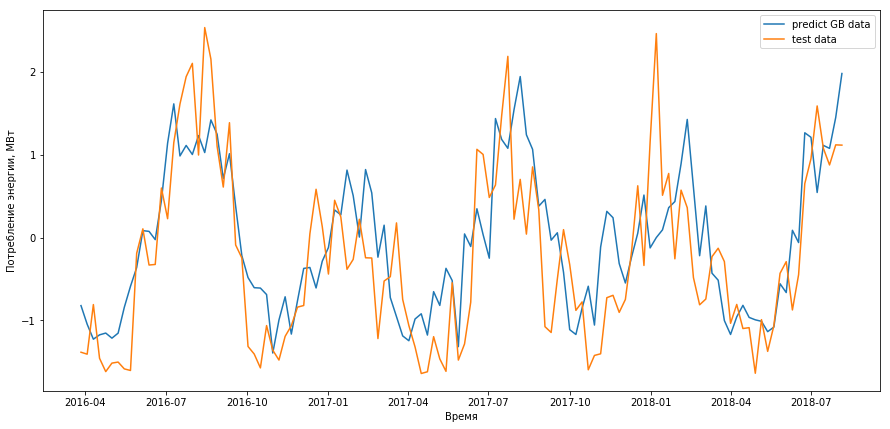

ошибка градиентного бустинга MAPE :   7.482142305147538 %


In [9]:
def split_data(data_w, split_date ):
    return data_w.loc[data_w.index.get_level_values('Date') <= split_date].copy(), \
           data_w.loc[data_w.index.get_level_values('Date') >  split_date].copy()



h = 4
p = 7

data_w = createFeatures(data_w, p)
X, y, scl_target = getXy(data_w, h, p)
features = getFeatures(X, y)

train, test = split_data( data_w, '01-06-2016')

modeling(X, y, train, test, features)

### 3.Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Номера признаков k лучших признаков :  [ 0 12 14 16 18]
Номера признаков лучших признаков по процентной форме:  [ 0 12 14 16]
Номера признаков для выбора по модели :  [ 0  3 12 22]
Отобранные признаки:  ['PJME_MW', 'weekofyear', 't1', 't2', 't3', 't4', 't6']


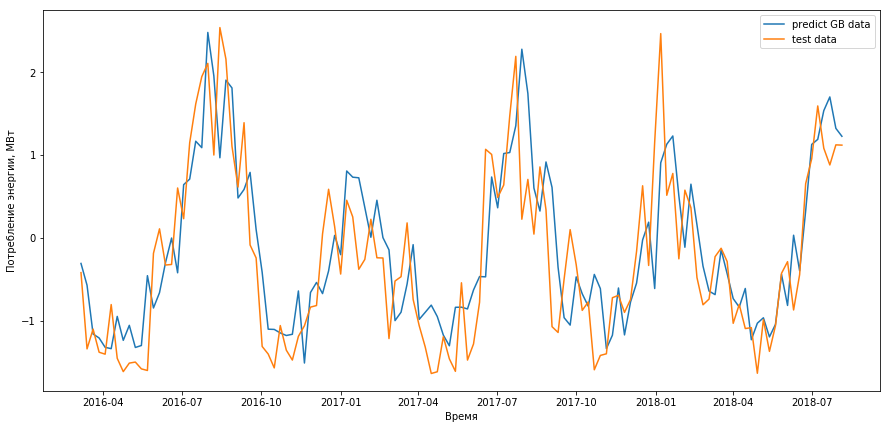

ошибка градиентного бустинга MAPE :   6.475309001991344 %


In [10]:
h = 1
p = 7

data_w = createFeatures(data_w, p)
X, y, _ = getXy(data_w, h, p)
features = getFeatures(X, y)
modeling(X, y, train, test, features)

### 4.Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.


In [11]:
h = 1
p = 7

data_w = createFeatures(data_w, p)
X, y, _ = getXy(data_w, h, p)
features = getFeatures(X, y)

X_new = X[:,features]

X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]


model = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model.fit( X_train, y_train )
y_pred = model.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Номера признаков k лучших признаков :  [ 0  9 12 14 16]
Номера признаков лучших признаков по процентной форме:  [ 0 12 14 16]
Номера признаков для выбора по модели :  [ 0  3 12 22]
Отобранные признаки:  ['PJME_MW', 'weekofyear', 'pca1', 't1', 't2', 't3', 't6']


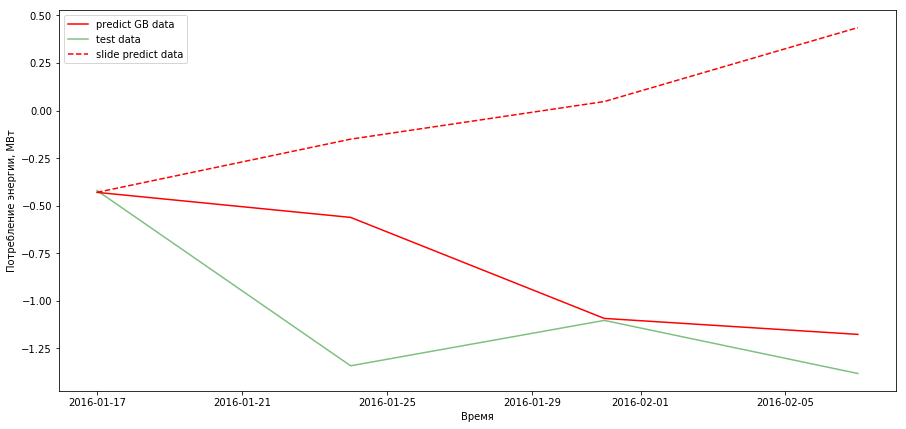

ошибка градиентного бустинга MAPE :   15.46931158250105 %


In [12]:
X_test_100 = X_test.copy()
y_test_100 = y_pred.copy()
N = 4
sph = len(features)

for i in range(N):
    y_test_100[i] = model.predict(X_test_100[i,:].reshape((1,sph)))
    # заполняем вектор для прогноза следующей точки
    X_test_100[i+1,0] = y_test_100[i]
    X_test_100[i+1,1] = X_test_100[i, 0]
    X_test_100[i+1,2] = 0 if i<2 else X_test_100[i-2, 0]
    X_test_100[i+1,3] = 0 if i<3 else X_test_100[i-3, 0]
    X_test_100[i+1,4] = 0 if i<4 else X_test_100[i-4, 0]
        
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N+1],y_pred[:N], 'r',label='predict GB data' )
plt.plot(test.index[1:N+1],y_test[:N], 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:N+1],y_test_100[:N], '--r',label='slide predict data')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true = scl_target.inverse_transform( y_test[:N]),
                                      y_pred = scl_target.inverse_transform( y_test_100[:N]))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

### 5.Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10i-й до (i+1)10 -й,... ,от 90 до 100-й точках (используйте осреднение по десяткам точек)


In [13]:
y_test_pred_g = model.predict(X_test)

In [14]:
scl_x=StandardScaler() 

X = data_w.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(858, 32)

In [15]:
scl_x.scale_[0] , scl_x.mean_[0]

(3993.3320793468615, 32086.18392209846)

In [16]:
X_test_100 = X_test.copy()
y_test_100 = y_test_pred_g.copy()

arr_er_g = {'Интервал':[],'НИТ':[]}
N10=100
for i in range(N10):
    y_test_100[i] = model.predict(X_test_100[i,:].reshape((1,X_test_100.shape[1])))
    # восстанавливаем не масштабированное значение ряда текущей точке  
    y_i=scl_target.inverse_transform(y_test_100[i:i+1])
    if i < y_test_100.shape[0]-1:
        # заполняем вектор для прогноза следующей точки
        X_test_100[i+1,0] = (y_i-scl_x.mean_[0])/scl_x.scale_[0]
        #строим 'd_w4' - признак под номером 2
        if i>=4:
            X_test_100[i+1,2] = np.mean(X_test_100[i-4+1:i,0])   
        if i>=1:
            X_test_100[i+1,3] = X_test_100[i-1+1,0]     
        if i>=2:
            X_test_100[i+1,4] = X_test_100[i-2+1,0]  
        if i>=3:
            X_test_100[i+1,5] = X_test_100[i-3+1,0]  
        if i>=7:
            X_test_100[i+1,6] = X_test_100[i-7+1,0]   
        X_test_100[i+1,1] = (np.log((y_i))-scl_x.mean_[6])*scl_x.scale_[6]
    if i % 10 == 9:
        er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test[i-9:i]),y_pred = scl_target.inverse_transform( y_test_100[i-9:i]))
        arr_er_g['Интервал'].append(er_g)
        er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test[:i]),y_pred = scl_target.inverse_transform( y_test_100[:i]))
        arr_er_g['НИТ'].append(er_g)

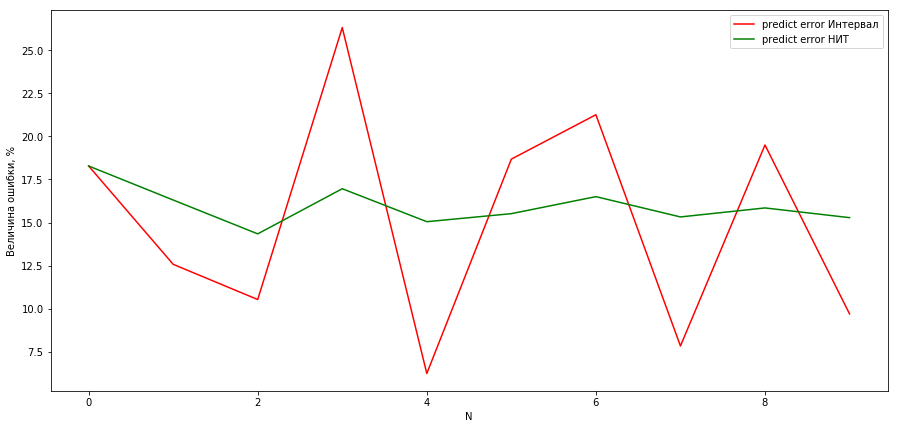

In [17]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('N')
plt.ylabel('Величина ошибки, %')
i = range(len(arr_er_g['Интервал']))
plt.plot(i ,arr_er_g['Интервал'], 'r',label='predict error Интервал' )
plt.plot(i ,arr_er_g['НИТ'], 'g',label='predict error НИТ' )
plt.legend()
plt.show()

### 6.Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда

### Ошибка меняется скачкообразно. До двух значение ошибки уменьшается, с двух до трех возрастает и снижается до четырех и т.д.